# Homework: Word Embedding

In this exercise, you will work on the skip-gram neural network architecture for Word2Vec. You will be using Keras to train your model. 

You must complete the following tasks:
1. Read/clean text files
2. Indexing (Assign a number to each word)
3. Create skip-grams (inputs for your model)
4. Create the skip-gram neural network model
5. Visualization
6. Evaluation (Using pre-trained, not using pre-trained)
    (classify topic from 4 categories) 
    
This notebook assumes you have already installed Tensorflow and Keras with python3 and had GPU enabled. If you run this exercise on GCloud using the provided disk image you are all set.



In [1]:
# %tensorflow_version 2.x
# %matplotlib inline
import numpy as np
import pandas as pd
import math
import glob
import re
import random
import collections
import os
import sys
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dense, Masking, Conv1D, Bidirectional
from tensorflow.python.keras.layers.merge import Dot
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

random.seed(42)

c:\Users\Kla\anaconda3\lib\site-packages\requests\__init__.py:78: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({0}) or chardet ({1}) doesn't match a supported "


# Step 1: Read/clean text files

The given code can be used to processed the pre-tokenzied text file from the wikipedia corpus. In your homework, you must replace those text files with raw text files.  You must use your own tokenizer to process your text files

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# import shutil
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/wiki.zip","/content/wiki.zip")
# shutil.copy("/content/drive/MyDrive/FRA 501 IntroNLP&DL/Dataset/BEST-TrainingSet.zip","/content/BEST-TrainingSet.zip")

In [4]:
# !unzip wiki.zip
# !unzip BEST-TrainingSet.zip

In [5]:
import re
#Step 1: read the wikipedia text file
with open("Dataset/wiki/thwiki_chk.txt") as f:
    #the delimiter is one or more whitespace characters
    input_text = re.compile(r"\s+").split(f.read()) 
    #exclude an empty string from our input
    input_text = [word for word in input_text if word != ''] 

In [6]:
tokens = input_text
print("total word count:", len(tokens))
print(tokens[:10])

total word count: 36349066
['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']


# Step 2: Indexing (Assign a number to each word)

The code below generates an indexed dataset(each word is represented by a number), a dictionary, a reversed dictionary

## <font color='yellow'>Homework Question 1:</font>
<font color='yellow'>“UNK” is often used to represent an unknown word (a word which does not exist in your dictionary/training set). You can also represent a rare word with this token as well.  How do you define a rare word in your program? Explain in your own words and capture the screenshot of your code segment that is a part of this process</font>

 + <font color='yellow'>edit or replace create_index with your own code to set a threshold for rare words and replace them with "UNK"</font>

Test function

In [7]:
# tokens = ['หน้า','หน้า','หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']

In [8]:
import collections
#step 2:Build dictionary and build a dataset(replace each word with its index)
def create_index(input_text, min_thres_unk = 1, max_word_count = None):
    # TODO#1 : edit or replace this function
    words = [word for word in input_text ]
    word_count = list()

    #use set and len to get the number of unique words
    word_count.extend(collections.Counter(words).most_common(len(set(words))))      #Counter(words) in list(word)

    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    # Detect Rare word 
    word_dict = {word:number for word,number in word_count}
    rare_word = [rare for rare in word_count if rare[:][1] <= min_thres_unk]
    word_count = [rare for rare in word_count if rare[:][1] > min_thres_unk]
    #include a token for unknown word
    word_count.append(("UNK",0+len(rare_word)))
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    #print out 10 most frequent words
    print('Word_count\t:',word_count[:13])                                               #When you run real code comment code
    print('Word_count\t:',word_count[len(word_count)-2:len(word_count)])                                               #When you run real code comment code

    
    dictionary = dict()
    dictionary["for_keras_zero_padding"] = 0
    for word in word_count:
        dictionary[word[0]] = len(dictionary)                                       # [dictionary] Create dictionary vocabulary # (Keyword,Tag_number)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))          # [reverse] Alternate Position of Keyword and Tag_number
    data = list()                                                                   # [dataset] Transform word to number in dictionary
    print('index_dict_UNK \t:',dictionary["UNK"])                                                                  
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
    for word in input_text:
        if word_dict[word] > min_thres_unk :
            data.append(dictionary[word])
        else:
            data.append(dictionary["UNK"])
    # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    return data,dictionary,reverse_dictionary,rare_word

# call method with min_thres_unk=1ß
dataset, dictionary, reverse_dictionary ,rare_word= create_index(tokens, 1)
print('rare_word\t:',len(rare_word))
print('rare_word[]\t:',rare_word[:11])
print('dataset \t:', dataset[:11])
print('len(dataset) \t:',len(dataset))
print('len(dictionary)\t:',len(dictionary))

Word_count	: [('ที่', 950006), ('ใน', 897329), ('เป็น', 726847), ('และ', 668116), ('การ', 619128), ('มี', 536738), ('ของ', 532237), ('ได้', 508117), (')', 359576), ('"', 357830), ('จาก', 315373), ('มา', 273144), ('ให้', 271729)]
Word_count	: [('เพาล์ดำรง', 2), ('UNK', 406192)]
index_dict_UNK 	: 295164
rare_word	: 406192
rare_word[]	: [('__NOEDITSECTION__', 1), ('โบราณสังเกต', 1), ('(ephemeris', 1), ('(astrometry', 1), ('ปรากฏการณ์จันทร', 1), ('-Battani', 1), ('Thebit', 1), ('เราต์', 1), ('(circumstellar', 1), ('bremsstrahlung', 1), ('อาศัยบัลลูน', 1)]
dataset 	: [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24, 4216]
len(dataset) 	: 36349066
len(dictionary)	: 295164


In [9]:
print("output sample (dataset):",dataset[:10])
print("output sample (dictionary):",{k: dictionary[k] for k in list(dictionary)[:10]})
print("output sample (reverse dictionary):",{k: reverse_dictionary[k] for k in list(reverse_dictionary)[:10]})

output sample (dataset): [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
output sample (dictionary): {'for_keras_zero_padding': 0, 'ที่': 1, 'ใน': 2, 'เป็น': 3, 'และ': 4, 'การ': 5, 'มี': 6, 'ของ': 7, 'ได้': 8, ')': 9}
output sample (reverse dictionary): {0: 'for_keras_zero_padding', 1: 'ที่', 2: 'ใน', 3: 'เป็น', 4: 'และ', 5: 'การ', 6: 'มี', 7: 'ของ', 8: 'ได้', 9: ')'}


# Step3: Create skip-grams (inputs for your model)
Keras has a skipgrams-generator, the cell below shows us how it generates skipgrams 

## <font color='yellow'>Homework Question 2:</font>
<font color='yellow'>The negative samples are sampled from sampling_table.  Look through Keras source code to find out how they sample negative samples. Discuss the sampling technique taught in class and compare it to the Keras source code.</font>



<font color='red'>Q2: PUT YOUR ANWSER HERE!!!</font>

ในการทำ Skip-gram 
1. สร้าง One-hot vector(x) และระบุ word target 
2. สร้าง Center word(Vc) จาก Embedded vector(V) ที่นำมา Dot กับ One-hot vector(x) 
3. สร้าง Score vector(Z) จาก Embedded vector(U) ที่นำมา Dot กับ Center word(Vc)
4. หา turn probailities จาก Softmax ของ Score vector(Z)
5. สร้าง Probailitiestrue vector จากการ Match One-hot vector ของผลลัพธ์กับ turn probabilties

แต่ในขั้นตอนของ negative samples ให้ขั้นตอนที่ 4 จะหา turn probailities จาก Sigmoid ของ Score vector(Z) แทน

จาก Code ด้านล่าง <br>
"skip_window = 1" คือจำนวน Context จาก Word target <br>
"sampling_table = sequence.make_sampling_table(vocab_size)" คือความน่าจะเป็นการสุ่มตัวอย่างคำศัพท์ <br>
"skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)" จะทำขั้นตอนที่ 1-5 และ return ออกมาเป็น Couples ที่ระบุคำคิดว่าเป็น context word ,Labels ที่ระบุว่า Couples นั้นๆเป็น context word หรือไม่

In [10]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import skipgrams
import numpy as np
# Step 3: Create data samples
vocab_size = len(dictionary)
print('vocab_size \t:',vocab_size)
skip_window = 1       # How many words to consider left and right.

# TODO#2 check out keras source code and find out how their sampling technique works. Describe it in your own words.
sample_set= dataset[:10]
print('sample_set \t:',sample_set)
print([reverse_dictionary[i] for i in sample_set])

sampling_table = sequence.make_sampling_table(vocab_size)
print('type of sampingtable \t:',type(sampling_table))
print('len(sampingtable) \t:',len(sampling_table))
print('Sampingtable  :\n',sampling_table[:48])

couples, labels = skipgrams(sample_set, vocab_size, window_size=skip_window, sampling_table=sampling_table)
word_target, word_context = zip(*couples)
word_target = np.array(word_target, dtype="int32")
word_context = np.array(word_context, dtype="int32")

print('Word_target&Word_context \t:',type(word_target),type(word_context))
print(couples, labels,len(labels))

for i in range(8):
    print(reverse_dictionary[couples[i][0]],reverse_dictionary[couples[i][1]])



vocab_size 	: 295164
sample_set 	: [229, 208, 2453, 573, 15, 1829, 7149, 3124, 681, 24]
['หน้า', 'หลัก', 'วิกิพีเดีย', 'ดำเนินการ', 'โดย', 'มูลนิธิ', 'วิกิ', 'มีเดีย', 'องค์กร', 'ไม่']
type of sampingtable 	: <class 'numpy.ndarray'>
len(sampingtable) 	: 295164
Sampingtable  :
 [0.00315225 0.00315225 0.00547597 0.00741556 0.00912817 0.01068435
 0.01212381 0.01347162 0.01474487 0.0159558  0.0171136  0.01822533
 0.01929662 0.02033198 0.02133515 0.02230924 0.02325687 0.02418031
 0.02508148 0.02596208 0.02682359 0.02766731 0.02849441 0.02930593
 0.03010279 0.03088585 0.03165585 0.0324135  0.03315943 0.0338942
 0.03461837 0.03533241 0.03603678 0.0367319  0.03741815 0.03809591
 0.0387655  0.03942724 0.04008143 0.04072834 0.04136824 0.04200136
 0.04262794 0.0432482  0.04386234 0.04447055 0.04507302 0.04566992]
Word_target&Word_context 	: <class 'numpy.ndarray'> <class 'numpy.ndarray'>
[[208, 83708], [208, 2453], [2453, 573], [208, 235515], [24, 681], [2453, 208], [3124, 145853], [2453, 115575]

# Step 4: create the skip-gram model
## <font color='yellow'>Homework Question 3:</font>
 <font color='yellow'>Q3:  In your own words, discuss why Sigmoid is chosen as the activation function in the  skip-gram model.</font>

<font color='red'>Q3: PUT YOUR ANSER HERE!!!</font>

เพื่อแปลง value เป็น probability แต่เนื่องจากเราเปลี่ยนค่า Vocab จาก multi class เป็น binary class <br>ดังนั้นการประมาณ Estimation Function จึงเปลี่ยนจาก Softmax เป็น Sigmoid

In [11]:
#reference: https://github.com/nzw0301/keras-examples/blob/master/Skip-gram-with-NS.ipynb
dim_embedddings = 32
V= len(dictionary)

#step1: select the embedding of the target word from W
w_inputs = Input(shape=(1, ), dtype='int32')
w = Embedding(V+1, dim_embedddings)(w_inputs)

#step2: select the embedding of the context word from C
c_inputs = Input(shape=(1, ), dtype='int32')
c  = Embedding(V+1, dim_embedddings)(c_inputs)

#step3: compute the dot product:c_k*v_j
o = Dot(axes=2)([w, c])
o = Reshape((1,), input_shape=(1, 1))(o)

#step4: normailize dot products into probability
o = Activation('sigmoid')(o)
#TO DO#4 Question: Why sigmoid?

SkipGram = Model(inputs=[w_inputs, c_inputs], outputs=o)
SkipGram.summary()
opt=Adam(lr=0.01)
SkipGram.compile(loss='binary_crossentropy', optimizer=opt)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 32)        9445280     ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        9445280     ['input_1[0][0]']                
                                                                                              

In [12]:
# # you don't have to spend too much time training for your homework, you are allowed to do it on a smaller corpus
# # currently the dataset is 1/20 of the full text file. 30 minute
# dataset = dataset[:int(len(dataset)/2)]
# print("dataset : ", len(dataset))
# for _ in range(5):
#     prev_i=0
#     #it is likely that your GPU won't be able to handle large input
#     #just do it 100000 words at a time
#     for i in range(len(dataset)//100000):
#         #generate skipgrams
#         data, labels = skipgrams(sequence=dataset[prev_i*100000:(i*100000)+100000], vocabulary_size=V, window_size=2, negative_samples=4.)
#         x = [np.array(x) for x in zip(*data)]
#         y = np.array(labels, dtype=np.int32)
#         if x:
#             loss = SkipGram.train_on_batch(x, y)
#         prev_i = i 
#         print(loss,i*100000)


In [13]:
# SkipGram.save_weights('Hw2-2_weight-10in20.h5')

In [14]:
SkipGram.load_weights('Weight\Hw2-2_weight-20in20.h5')

In [15]:
#Get weight of the embedding layer
final_embeddings=SkipGram.get_weights()[0]
print(final_embeddings)
print(final_embeddings.shape)

[[ 0.02942849 -0.01651738  0.00090514 ... -0.0396731  -0.00961649
   0.0410727 ]
 [ 0.47761682  0.5249094  -0.513467   ... -0.44100836  0.4983482
  -0.44176435]
 [ 0.53711545  0.49662948 -0.5075311  ... -0.5000523   0.5469739
  -0.46958375]
 ...
 [-0.2775476  -0.33840984  0.3283808  ...  0.35071477 -0.32958984
   0.31069124]
 [-0.30097756 -0.3587501   0.2835574  ...  0.29093605 -0.32598704
   0.31950703]
 [ 0.608721    0.6070169  -0.6186583  ... -0.61935073  0.64566165
  -0.6378556 ]]
(295165, 32)


# Step 5: Intrinsic Evaluation: Word Vector Analogies
## <font color='yellow'>Homework Question 4: </font>
<font color='yellow'> Read section 2.1 and 2.3 in this [lecture note](http://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes02-wordvecs2.pdf). Come up with 10 semantic analogy examples and report results produced by your word embeddings. Discuss t-SNE in 2 dimensions. </font>


In [16]:
# TODO#4:Come up with 10 semantic analogy examples and report results produced by your word embeddings anf do t-SNE in 2 dimensions.
#and tell us what you observe 

## Analogy

In [28]:
final_embeddings[dictionary["ประเทศไทย"]]

array([ 0.171969  ,  0.16089247, -0.17352885,  0.2119224 ,  0.19270985,
       -0.16091071, -0.11357863, -0.14748596, -0.16138722,  0.20939434,
        0.26420844,  0.21547832, -0.19697753, -0.221482  ,  0.19791767,
       -0.13680393,  0.181587  ,  0.19390102, -0.2665418 , -0.2395119 ,
        0.18737996, -0.19710226, -0.26718366, -0.2242186 , -0.22760895,
       -0.22198859,  0.20428312, -0.24278554,  0.19157171, -0.26173127,
        0.268389  , -0.25113934], dtype=float32)

In [30]:
import scipy
from scipy import spatial
#scipy also provides you with a module that you can use to compare your target words against all the words in your corpus
v = final_embeddings[dictionary["55"]].reshape(1, -1)
#just compare with top 10000 words....
all_dist = spatial.distance.cdist(final_embeddings[:10000], v, 'cosine').reshape(-1)
# get 20 nearest vector 
# argpartition can get top twenty very quickly, but they are not sorted
idx =np.argpartition(all_dist, 20)[:20]
#sort
idx = idx[np.argsort(all_dist[idx[:20]])]

for i in idx:
    print(reverse_dictionary[i])

55
35
39
45
50
แล
75
37
41
40
95
44
30
80
ประสูติ
14
น
0
กันยายน
70


## t-SNE

In [32]:
# import matplotlib
# import matplotlib.font_manager as fm

# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# font_manager = fm.FontManager()
# font_manager.addfont('thsarabunnew-webfont.ttf')
# matplotlib.rc('font', family='TH Sarabun New')

In [33]:
import matplotlib.font_manager as fm
def plot_with_labels(low_dim_embs, labels, filename="tsne_plot.png"):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(15, 15))  # in inches
    plt.axis('off')
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        prop = fm.FontProperties(fname=f'thsarabunnew-webfont.ttf',size=10)
        plt.annotate(label,
                     fontproperties=prop,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        
 
    plt.show()
    plt.savefig(filename)

c:\Users\Kla\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Kla\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


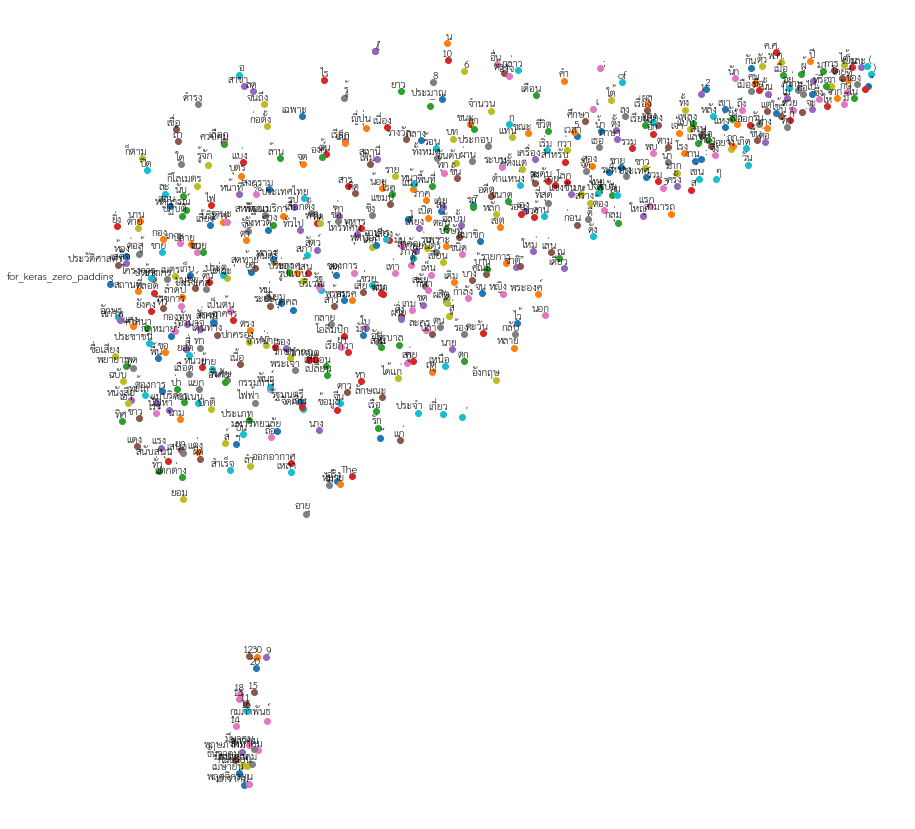

<Figure size 432x288 with 0 Axes>

In [34]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib as mpl

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500)
plot_only = 500 #only top 500 words
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plt.rcParams['font.family'] = 'TH Sarabun New'
plot_with_labels(low_dim_embs, labels)

# Step 6: Extrinsic Evaluation

## <font color='yellow'>Homework Question5:</font>
<font color='yellow'>
Use the word embeddings from the skip-gram model as pre-trained weights (GloVe and fastText) in a classification model. Compare the result the with the same classification model that does not use the pre-trained weights. 
</font>


In [36]:
all_news_filepath = glob.glob('Dataset/BEST-TrainingSet/news/*.txt')
all_novel_filepath = glob.glob('Dataset/BEST-TrainingSet/novel/*.txt')
all_article_filepath = glob.glob('Dataset/BEST-TrainingSet/article/*.txt')
all_encyclopedia_filepath = glob.glob('Dataset/BEST-TrainingSet/encyclopedia/*.txt')

In [38]:
print(type(all_article_filepath))
print(len(all_article_filepath))
print(all_article_filepath[:10])

<class 'list'>
195
['Dataset/BEST-TrainingSet/article\\article_00001.txt', 'Dataset/BEST-TrainingSet/article\\article_00002.txt', 'Dataset/BEST-TrainingSet/article\\article_00003.txt', 'Dataset/BEST-TrainingSet/article\\article_00004.txt', 'Dataset/BEST-TrainingSet/article\\article_00005.txt', 'Dataset/BEST-TrainingSet/article\\article_00006.txt', 'Dataset/BEST-TrainingSet/article\\article_00007.txt', 'Dataset/BEST-TrainingSet/article\\article_00008.txt', 'Dataset/BEST-TrainingSet/article\\article_00009.txt', 'Dataset/BEST-TrainingSet/article\\article_00010.txt']


In [ ]:
#preparing data for the classificaiton model
#In your homework, we will only use the first 2000 words in each text file
#any text file that has less than 2000 words will be padded
#reason:just to make this homework feasible under limited time and resource
max_length = 2000
def word_to_index(word):
    if word in dictionary:
        return dictionary[word]
    else:#if unknown
        return dictionary["UNK"]


def prep_data():
    input_text = list()
    for textfile_path in [all_news_filepath, all_novel_filepath, all_article_filepath, all_encyclopedia_filepath]:
        for input_file in textfile_path:
            f = open(input_file,"r") #open file with name of "*.txt"
            text = re.sub(r'\|', ' ', f.read()) # replace separation symbol with white space           
            text = re.sub(r'<\W?\w+>', '', text)# remove <NE> </NE> <AB> </AB> tags
            text = text.split() #split() method without an argument splits on whitespace 
            indexed_text = list(map(lambda x:word_to_index(x), text[:max_length])) #map raw word string to its index   
            if 'news' in input_file:
                input_text.append([indexed_text,0]) 
            elif 'novel' in input_file:
                input_text.append([indexed_text,1]) 
            elif 'article' in input_file:
                input_text.append([indexed_text,2]) 
            elif 'encyclopedia' in input_file:
                input_text.append([indexed_text,3]) 
            
            f.close()
    random.shuffle(input_text)
    return input_text

input_data = prep_data()
train_data = input_data[:int(len(input_data)*0.6)]
val_data = input_data[int(len(input_data)*0.6):int(len(input_data)*0.8)]
test_data = input_data[int(len(input_data)*0.8):]

train_input = [data[0] for data in train_data]
train_input = sequence.pad_sequences(train_input, maxlen=max_length) #padding
train_target = [data[1] for data in train_data]
train_target=to_categorical(train_target, num_classes=4)

val_input = [data[0] for data in val_data]
val_input = sequence.pad_sequences(val_input, maxlen=max_length) #padding
val_target = [data[1] for data in val_data]
val_target=to_categorical(val_target, num_classes=4)

test_input = [data[0] for data in test_data]
test_input = sequence.pad_sequences(test_input, maxlen=max_length) #padding
test_target = [data[1] for data in test_data]
test_target=to_categorical(test_target, num_classes=4)

del input_data, val_data,train_data, test_data

In [ ]:
#the classification model
#TODO#5 find out how to initialize your embedding layer with pre-trained weights, evaluate and observe
#don't forget to compare it with the same model that does not use pre-trained weights
#you can use your own model too! and feel free to customize this model as you wish
# more information --> https://keras.io/examples/nlp/pretrained_word_embeddings/
# fastText --> https://fasttext.cc/docs/en/crawl-vectors.html (optional)
# !wget --no-check-certificate https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

cls_model = Sequential()
cls_model.add(Embedding(len(dictionary)+1, 32, input_length=max_length,mask_zero=True)) 
cls_model.add(GRU(32))
cls_model.add(Dropout(0.5))
cls_model.add(Dense(4, activation='softmax'))
opt=Adam(lr=0.01)
cls_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
cls_model.summary()
print('Train...')
cls_model.fit(train_input, train_target,
          epochs=10,
          validation_data=[val_input, val_target])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 2000, 32)          9445280   
                                                                 
 gru_5 (GRU)                 (None, 32)                6336      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 9,451,748
Trainable params: 9,451,748
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/10


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

In [ ]:
results = cls_model.evaluate(test_input, test_target)
print("test loss, test acc:", results)